In [86]:
# if you need to install openptv-python, it's recommended to use conda

# Create conda environment with openptv-python
# conda create -n openptv_lineofsight python=3.10
# conda activate openptv_lineofsight
# pip install git+https://github.com/openptv/openptv-python.git
# conda install jupyter matplotlib numpy numba

In [87]:
from openptv_python.calibration import Calibration
from openptv_python.parameters import ControlPar, VolumePar
from openptv_python.trafo import pixel_to_metric, dist_to_flat
from openptv_python.multimed import ray_tracing, move_along_ray
import numpy as np
import matplotlib.pyplot as plt



In [88]:
# openptv way to get the line in 3D from the point in the image space and 
# the calibration parameters


def epipolar_curve_in_3D(
    image_point,
    origin_cam: Calibration,
    num_points: int,
    cparam: ControlPar,
    vparam: VolumePar,
) -> np.ndarray:
    """
    Get the points lying on the epipolar line from one camera to the other, on.

    the edges of the observed volume. Gives pixel coordinates.

    Assumes the same volume applies to all cameras.

    Arguments:
    ---------
    image_point - the 2D point on the image
        plane of the camera seeing the point. Distorted pixel coordinates.
    Calibration origin_cam - current position and other parameters of the
        camera seeing the point.
    int num_points - the number of points to generate along the line. Minimum
        is 2 for both endpoints.
    ControlParams cparam - an object holding general control parameters.
    VolumeParams vparam - an object holding observed volume size parameters.

    Returns
    -------
    line_points - (num_points,2) array with projection camera image coordinates
        of points lying on the ray stretching from the minimal Z coordinate of
        the observed volume to the maximal Z thereof, and connecting the camera
        with the image point on the origin camera.
    """

    line_points = np.empty((num_points, 3))

    # Move from distorted pixel coordinates to straight metric coordinates.
    x, y = pixel_to_metric(image_point[0], image_point[1], cparam)
    x, y = dist_to_flat(x, y, origin_cam, 0.00001)

    vertex, direct = ray_tracing(x, y, origin_cam, cparam.mm)

    for pt_ix, Z in enumerate(
        np.linspace(vparam.z_min_lay[0], vparam.z_max_lay[0], num_points)
    ):
        # x = line_points[pt_ix], 0)
        # y = <double *>np.PyArray_GETPTR2(line_points, pt_ix, 1)

        line_points[pt_ix, :] = move_along_ray(Z, vertex, direct)
        
        # x, y = img_coord(pos, project_cam, cparam.mm)
        # line_points[pt_ix, 0], line_points[pt_ix, 1] = metric_to_pixel(x, y, cparam)

    return line_points

In [89]:
!ls '/home/user/Downloads/rbc300'

cal		    parameters		       parametersPlane2  res
calibration_images  parametersBackup	       parametersPlane3  tmp.addpar
cal.zip		    parametersMultiPlane       parametersPlane4
img		    parameters_MultiPlane_Run  parametersPlane5
man_ori.dat	    parametersPlane1	       particle_images


In [90]:
# Read the required stuff from the working folder
import pathlib, os
working_path = pathlib.Path('/home/user/Downloads/rbc300')
calibration = Calibration().from_file(os.path.join(working_path,"cal","cam1.tif.ori"), None )
control_parameters = ControlPar().from_file(os.path.join(working_path,"parameters","ptv.par"))
volume_parameters = VolumePar().from_file(os.path.join(working_path,"parameters","criteria.par"))

no addpar file, use default values 0 0 0 0 0 1 0


In [91]:
calibration.ext_par, control_parameters.num_cams, volume_parameters.z_min_lay, volume_parameters.z_max_lay

(rec.array((328.98208759, -28.87301302, 945.67240814, 0.17977266, 0.20028117, -0.03212693, [[ 0.97950497,  0.03147932,  0.19894489], [ 0.00395042,  0.9845193 , -0.17523169], [-0.20138126,  0.17242623,  0.96421719]]),
           dtype=[('x0', '<f8'), ('y0', '<f8'), ('z0', '<f8'), ('omega', '<f8'), ('phi', '<f8'), ('kappa', '<f8'), ('dm', '<f8', (3, 3))]),
 4,
 [-150.0, -150.0],
 [150.0, 150.0])

In [92]:
curve_3D = epipolar_curve_in_3D(
    image_point=np.array([0,0]),
    origin_cam = calibration,
    num_points = 10,
    cparam = control_parameters,
    vparam = volume_parameters,
)

In [93]:
cam_position = calibration.get_pos()

In [94]:
cam_position

array([328.98208759, -28.87301302, 945.67240814])

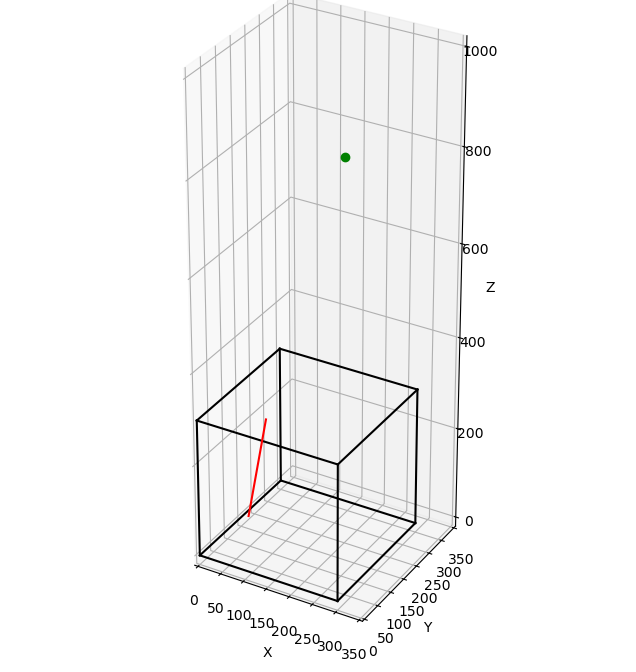

In [95]:
# plot line of sight
axis = plt.figure(figsize=(10,8)).add_subplot(projection='3d')
axis.set_xlabel('X'), axis.set_ylabel('Y'), axis.set_zlabel('Z')
axis.set_xlim(0,350), axis.set_ylim(0,350), axis.set_zlim(0,1000)
axis.set_aspect('equal')

axis.plot([0,300],[0,0],[0,0],c='black'), axis.plot([0,0],[0,300],[0,0],c='black'), axis.plot([0,0],[0,0],[0,300],c='black')
axis.plot([300,300],[0,300],[0,0],c='black'), axis.plot([300,300],[0,0],[0,300],c='black'), axis.plot([0,300],[300,300],[0,0],c='black')
axis.plot([0,0],[300,300],[0,300],c='black'), axis.plot([0,300],[0,0],[300,300],c='black'), axis.plot([0,0],[0,300],[300,300],c='black')
axis.plot([300,300],[300,300],[0,300],c='black'), axis.plot([300,300],[0,300],[300,300],c='black'), axis.plot([0,300],[300,300],[300,300],c='black')
# for lof in LOF:
#     plt.plot( [lof[0,0],lof[0,0]+mu*lof[1,0]] , [lof[0,1],lof[0,1]+mu*lof[1,1]] , [lof[0,2],lof[0,2]+mu*lof[1,2]] ,'-',c='red')
plt.plot(cam_position[0],cam_position[1],cam_position[2],'o',c='green')
plt.plot(curve_3D[:,0],curve_3D[:,1],curve_3D[:,2],'-',c='red')